# Figure 11: Accuracy difference w/ and w/o Dropout in supervised learning.

[:simple-jupyter: :material-download:](/papers/imc23/notebooks/figure11_dropout_impact_supervised_setting.ipynb)

In [1]:
import itertools
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.api as sms

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
RENAME = {
    "noaug": "No aug.",
    "rotate": "Rotate",
    "colorjitter": "Color jitter",
    "horizontalflip": "Horizontal flip",
    "changertt": "Change RTT",
    "timeshift": "Time shift",
    "packetloss": "Packet loss",
}

In [3]:
folder = pathlib.Path(
    "./campaigns/ucdavis-icdm19/augmentation-at-loading-dropout-impact/campaign_summary/augment-at-loading-dropout-impact/"
)

In [4]:
df = pd.concat(
    [
        pd.read_parquet(folder / f"runsinfo_flowpic_dim_{flowpic_dim}.parquet")
        for flowpic_dim in (32, 1500)
    ]
)

In [5]:
df = df[
    [
        "flowpic_dim",
        "test_split_name",
        "aug_name",
        "seed",
        "split_index",
        "acc",
        "with_dropout",
    ]
]

In [6]:
df = df[df["test_split_name"] != "test-train-val-leftover"]
df = df.replace(RENAME)

In [7]:
df_with_dropout = (
    df[df["with_dropout"] == True]
    .drop("with_dropout", axis=1)
    .rename({"acc": "withdropout_acc"}, axis=1)
)

df_no_dropout = (
    df[df["with_dropout"] == False]
    .drop("with_dropout", axis=1)
    .rename({"acc": "nodropout_acc"}, axis=1)
)

In [8]:
df = pd.merge(
    df_with_dropout,
    df_no_dropout,
    on=[
        "flowpic_dim",
        "test_split_name",
        "aug_name",
        "seed",
        "split_index",
    ],
    suffixes=["withdropout_", "nodropout_"],
)

In [9]:
df = df.iloc[df["nodropout_acc"].dropna().index]

In [10]:
df["acc_diff"] = df["withdropout_acc"] - df["nodropout_acc"]

In [11]:
def compute_confidence_intervals(array, alpha=0.05):
    array = np.array(array)
    low, high = sms.DescrStatsW(array).tconfint_mean(alpha)
    mean = array.mean()
    ci = high - mean
    return ci

In [12]:
df_merged = df.groupby(["flowpic_dim", "test_split_name", "aug_name"]).agg(
    {"acc_diff": ["mean", "std", "count", "min", "max", compute_confidence_intervals]}
)
df_merged = df_merged.rename(
    columns={"compute_confidence_intervals": "confidence_interval"}
)
df_merged = df_merged.droplevel(0, axis=1)

In [13]:
df_merged

mean       std  count  \
flowpic_dim test_split_name aug_name                                         
32          test-human      Change RTT       1.606426e-01  2.650081     15   
                            Color jitter     1.285141e+00  5.100786     15   
                            Horizontal flip -1.044177e+00  2.727209     15   
                            No aug.         -9.638554e-01  2.584049     15   
                            Packet loss      2.409639e-01  2.922951     15   
                            Rotate           1.124498e+00  3.712572     15   
                            Time shift      -4.016064e-01  3.366931     15   
            test-script     Change RTT       3.555556e-01  0.660287     15   
                            Color jitter     8.444444e-01  1.413465     15   
                            Horizontal flip  3.555556e-01  1.330155     15   
                            No aug.         -1.777778e-01  0.815200     15   
                            Packet loss      7.111111e-01  1.139943     15   
                            Rotate           2.222222e-01  0.860663     15   
                            Time shift      -2.222222e-01  1.172886     15   
1500        test-human      Change RTT      -3.212851e-01  2.711959     15   
                            Color jitter     1.927711e+00  1.866498     15   
                            Horizontal flip  9.638554e-01  1.942713     15   
                            No aug.         -2.368476e-15  3.643031     15   
                            Packet loss      1.285141e+00  3.795431     15   
                            Rotate          -8.032129e-02  2.896821     15   
                            Time shift       6.425703e-01  3.215719     15   
            test-script     Change RTT       8.888889e-02  1.003697     15   
                            Color jitter     9.333333e-01  1.980861     15   
                            Horizontal flip  7.555556e-01  1.094479     15   
                            No aug.          4.000000e-01  1.848208     15   
                            Packet loss      1.866667e+00  1.802996     15   
                            Rotate           2.666667e-01  1.609496     15   
                            Time shift       8.888889e-01  1.811194     15   

                                                  min       max  \
flowpic_dim test_split_name aug_name                              
32          test-human      Change RTT      -6.024096  4.819277   
                            Color jitter    -8.433735  7.228916   
                            Horizontal flip -4.819277  6.024096   
                            No aug.         -4.819277  2.409639   
                            Packet loss     -3.614458  6.024096   
                            Rotate          -7.228916  6.024096   
                            Time shift      -6.024096  6.024096   
            test-script     Change RTT      -0.666667  1.333333   
                            Color jitter    -1.333333  3.333333   
                            Horizontal flip -2.666667  2.666667   
                            No aug.         -2.000000  0.666667   
                            Packet loss     -1.333333  2.666667   
                            Rotate          -0.666667  2.000000   
                            Time shift      -2.000000  2.000000   
1500        test-human      Change RTT      -4.819277  6.024096   
                            Color jitter    -1.204819  6.024096   
                            Horizontal flip -2.409639  3.614458   
                            No aug.         -4.819277  7.228916   
                            Packet loss     -3.614458  9.638554   
                            Rotate          -4.819277  4.819277   
                            Time shift      -3.614458  7.228916   
            test-script     Change RTT      -1.333333  2.666667   
                            Color jitter    -3.333333  5.333333   
                            Horizonta

/tmp/ipykernel_97694/3765097497.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(df_tmp.index), rotation=90, ha="center")
/tmp/ipykernel_97694/3765097497.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(df_tmp.index), rotation=90, ha="center")
/tmp/ipykernel_97694/3765097497.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(df_tmp.index), rotation=90, ha="center")
/tmp/ipykernel_97694/3765097497.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(df_tmp.index), rotation=90, ha="center")


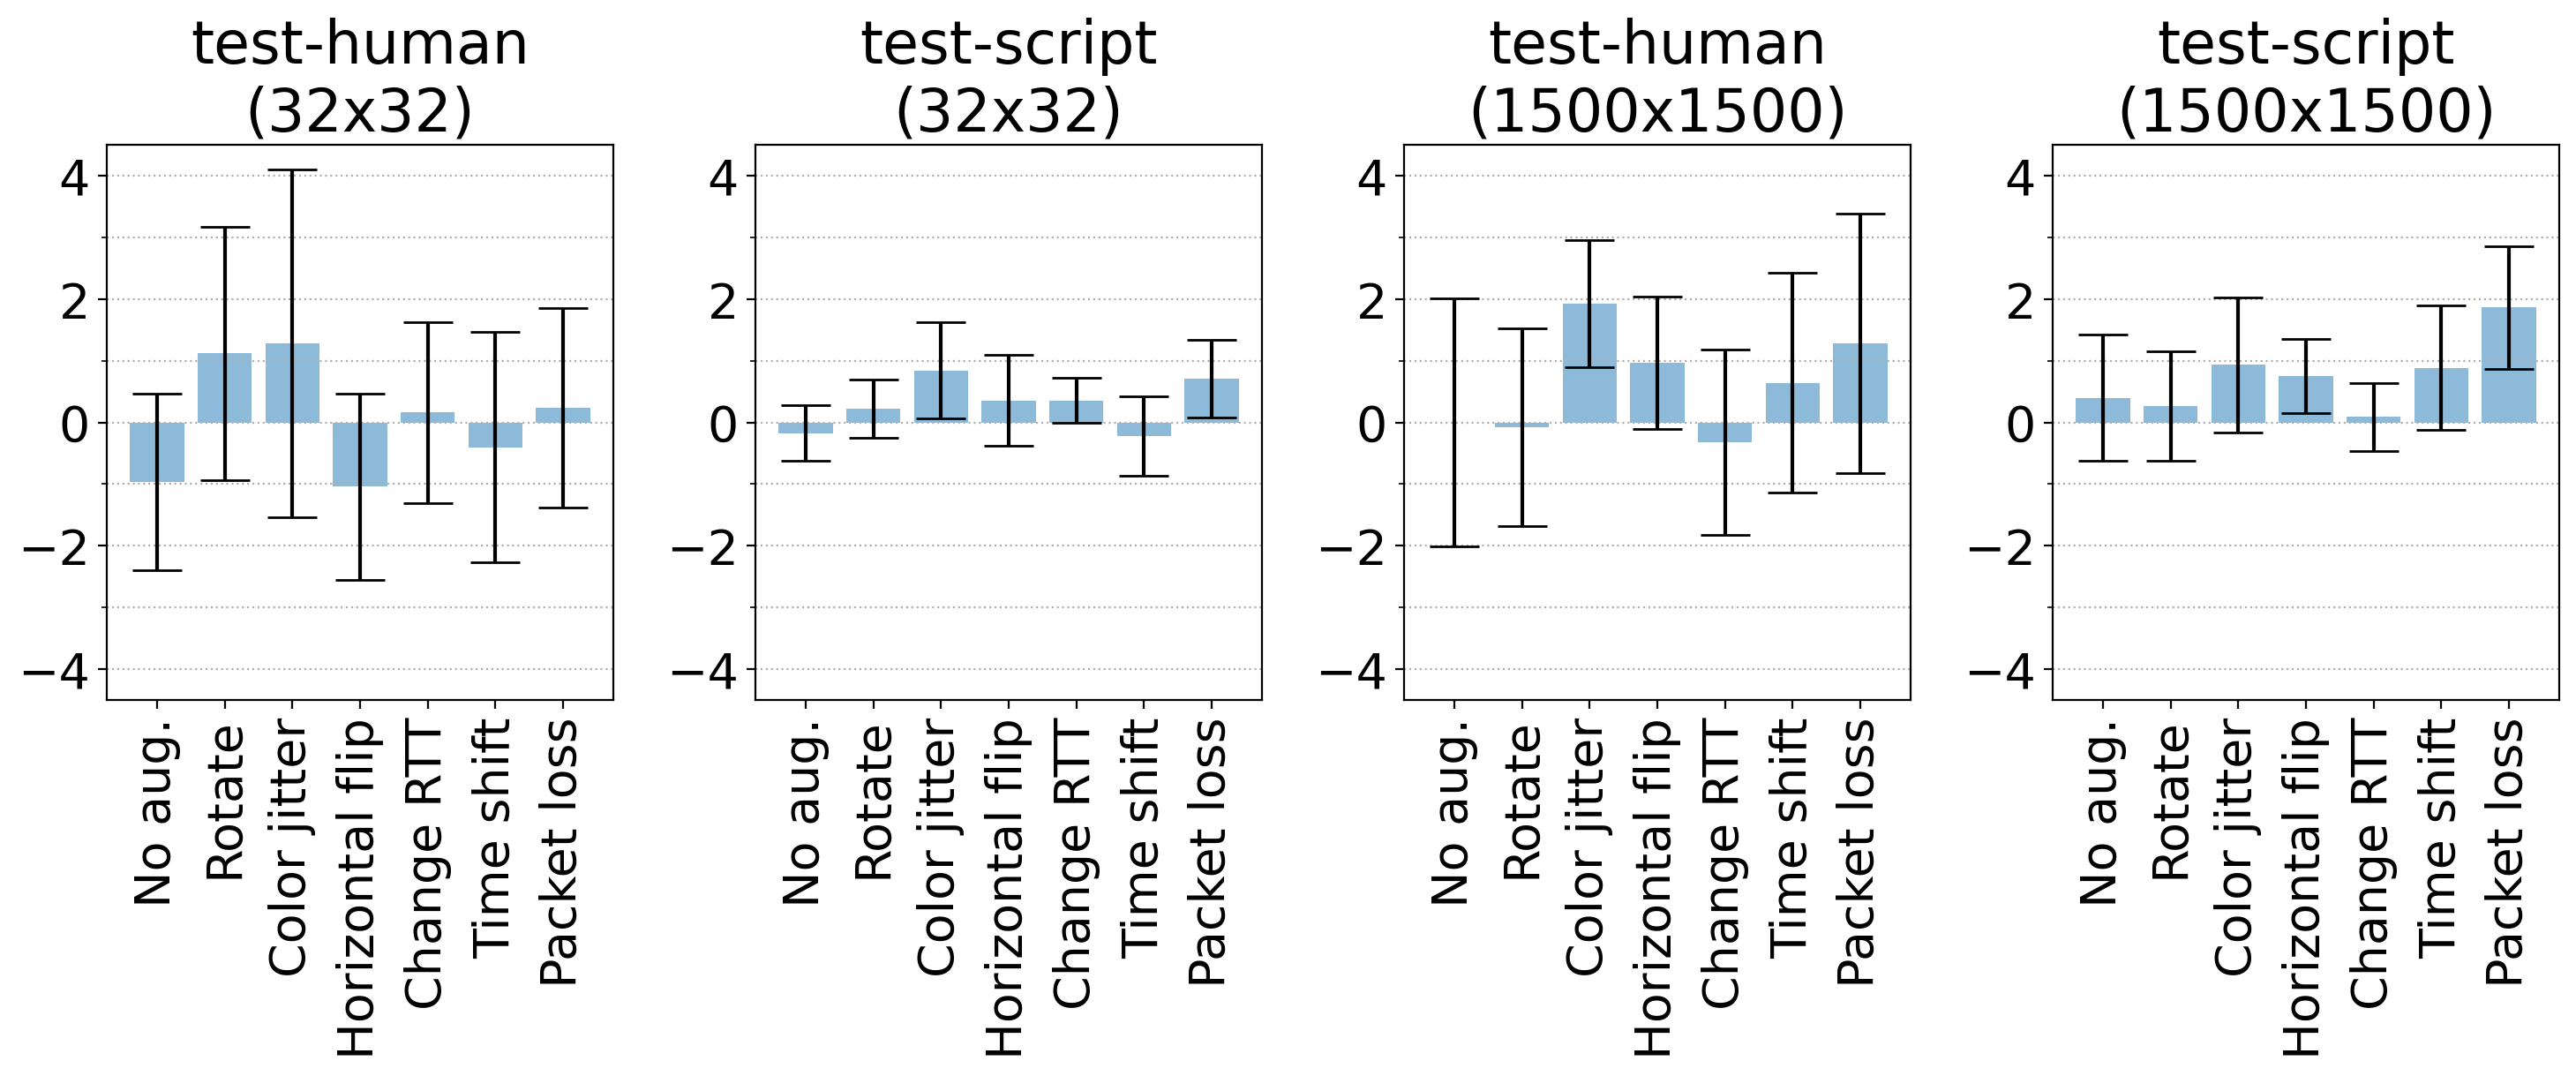

In [18]:
plt.rcParams.update({"font.size": 20})

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6.5))

for ax, (flowpic_dim, test_split_name) in zip(
    axes.flatten(), itertools.product((32, 1500), ("test-human", "test-script"))
):
    df_tmp = df_merged.loc[(flowpic_dim, test_split_name)]
    df_tmp = df_tmp.loc[list(RENAME.values())]

    ax.bar(
        list(df_tmp.index),
        df_tmp["mean"],
        yerr=df_tmp["confidence_interval"],
        align="center",
        alpha=0.5,
        ecolor="black",
        capsize=10,
    )

    ax.set_title(f"{test_split_name}\n({flowpic_dim}x{flowpic_dim})")

    ax.set_xticklabels(list(df_tmp.index), rotation=90, ha="center")
    ax.set_ylim(-4.5, 4.5)
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    ax.grid(axis="y", which="both", linestyle=":")

plt.tight_layout()
plt.savefig("supervised_dropout_std.png", dpi=300, bbox_inches="tight")